# Задание от компании Devim

Исполнитель: Кудюров Владислав

Необходимо на основе предоставленных данных построить модель для предсказания
целевой переменной. Сделать описание проделанных шагов:

● Анализ данных

● Фильтрация

● Преобразование переменных

● Моделирование

● Оценка качества модели

Обоснование выбранной метрики качества. Подробно описать способ оценки качества построенной модели.

In [5]:
# Подключим библиотеки
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import pandas as pd
from google.colab import files
import numpy as np

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()


In [6]:
# Подключим диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Анализ Данных

Иформация о переменных
Переменные, характеризующие кредитную историю клиента

closed_cred_sum - сумма, которую клиент выплатил по ранее взятым и закрытым кредитам

closed_creds - количество закрытых кредитов

active_cred_sum_overdue - суммарная задолженность по активным кредитам

active_cred_sum - сумма всех активных кредитов

active_cred_day_overdue - суммарная просрочка в днях по всем активным кредитам

active_cred_max_overdue - максимальная сумма просроченной задолженности по активным кредитам

Переменные характеризующие клиента

age - возраст

gender - пол

region - регион

month_income - ежемесячный доход

Переменные, характеризующие кредит, по которому нужно сделать прогноз

first_loan - сумма, которую клиент хочет получить в кредит (из заявки)

first_days_quant - срок, на которую клиент хочет взять кредит

loan_cost_all - одобренная клиенту сумма кредита

order_date - дата подачи заявки на получение кредита

cost_all - сумма всех выплат по одобренному кредиту

order_id - id заявки

client_id - id клиента

Целевая переменная:

expert - решение, которое принято по заявке (0 - одобрено, 1 - отклонено)

In [7]:
# Загрузка данных
df = pd.read_csv('/content/drive/My Drive/datasets/test_Devim/data.csv', sep=';')
df.index += 1
df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 1 to 50001
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   closed_cred_sum          50001 non-null  float64
 1   closed_creds             50001 non-null  int64  
 2   active_cred_sum_overdue  50001 non-null  float64
 3   active_cred_sum          50001 non-null  float64
 4   active_cred_day_overdue  50001 non-null  int64  
 5   active_cred_max_overdue  50001 non-null  float64
 6   age                      50001 non-null  int64  
 7   gender                   50001 non-null  int64  
 8   region                   50001 non-null  int64  
 9   first_loan               49982 non-null  float64
 10  loan_cost_all            50001 non-null  int64  
 11  first_days_quant         50001 non-null  int64  
 12  month_income             50001 non-null  float64
 13  order_date               50001 non-null  object 
 14  cost_all              

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,order_id,client_id,expert
1,143822.00,22,104.12,130068.80,8,756.09,31,0,36,10000.0,10000,196,0.0,2017-07-23,0.0,728319,320464,1
2,0.00,0,38151.93,46230.00,1492,38151.93,51,0,93,10000.0,10000,17,20000.0,2017-07-23,0.0,728321,320466,1
3,51356.00,2,3000.00,3000.00,8,3000.00,28,1,3,10000.0,10000,84,0.0,2017-07-23,0.0,728323,320467,1
4,0.00,0,22784.19,32103.52,913,22784.19,28,0,52,10000.0,10000,7,0.0,2017-07-23,0.0,728447,320533,1
5,12298.00,1,4942.95,4950.00,2883,4942.95,31,0,47,5000.0,5000,20,0.0,2017-07-23,0.0,728421,298598,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49997,0.00,0,74662.61,79662.61,2593,42204.55,27,1,0,4000.0,4000,20,0.0,2017-08-13,0.0,759472,96091,1
49998,21653.49,2,0.00,0.00,0,0.00,28,0,75,2000.0,2000,10,20000.0,2017-08-13,0.0,759475,338240,1
49999,0.00,0,0.00,1000.00,0,941.00,22,0,0,10000.0,10000,20,35000.0,2017-08-13,0.0,759485,338246,1
50000,0.00,0,0.00,1000.00,0,941.00,22,0,0,10000.0,10000,20,35000.0,2017-08-13,0.0,759485,338246,1


In [8]:
# Проверка датасета на отсутствие данных 
df.isna().sum()

closed_cred_sum             0
closed_creds                0
active_cred_sum_overdue     0
active_cred_sum             0
active_cred_day_overdue     0
active_cred_max_overdue     0
age                         0
gender                      0
region                      0
first_loan                 19
loan_cost_all               0
first_days_quant            0
month_income                0
order_date                  0
cost_all                    0
order_id                    0
client_id                   0
expert                      0
dtype: int64

In [9]:
# Функция для вычисления процентного списка пропущенных данных
def get_persent(fn):
  try:
    for col in fn.columns:
      pct_missing = np.mean(fn[col].isnull())
      print('{} - {}%'.format(col, round(pct_missing*100, 3)))
  except ValueError:
    print('Error DataFrame')

get_persent(df)

closed_cred_sum - 0.0%
closed_creds - 0.0%
active_cred_sum_overdue - 0.0%
active_cred_sum - 0.0%
active_cred_day_overdue - 0.0%
active_cred_max_overdue - 0.0%
age - 0.0%
gender - 0.0%
region - 0.0%
first_loan - 0.038%
loan_cost_all - 0.0%
first_days_quant - 0.0%
month_income - 0.0%
order_date - 0.0%
cost_all - 0.0%
order_id - 0.0%
client_id - 0.0%
expert - 0.0%


In [10]:
# Заменим пропуски медианной в переменной first_loan
df['first_loan'] = df['first_loan'].fillna(df['first_loan'].median())
df.isna().sum()

closed_cred_sum            0
closed_creds               0
active_cred_sum_overdue    0
active_cred_sum            0
active_cred_day_overdue    0
active_cred_max_overdue    0
age                        0
gender                     0
region                     0
first_loan                 0
loan_cost_all              0
first_days_quant           0
month_income               0
order_date                 0
cost_all                   0
order_id                   0
client_id                  0
expert                     0
dtype: int64

# Фильтрация

In [11]:
# Удалим ненужный столбец длч дальнейшего анализа
df = df.drop(['order_date'], axis=1)
df.head()

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,cost_all,order_id,client_id,expert
1,143822.0,22,104.12,130068.80,8,756.09,31,0,36,10000.0,10000,196,0.0,0.0,728319,320464,1
2,0.0,0,38151.93,46230.00,1492,38151.93,51,0,93,10000.0,10000,17,20000.0,0.0,728321,320466,1
3,51356.0,2,3000.00,3000.00,8,3000.00,28,1,3,10000.0,10000,84,0.0,0.0,728323,320467,1
4,0.0,0,22784.19,32103.52,913,22784.19,28,0,52,10000.0,10000,7,0.0,0.0,728447,320533,1
5,12298.0,1,4942.95,4950.00,2883,4942.95,31,0,47,5000.0,5000,20,0.0,0.0,728421,298598,1


In [12]:
# Оценим баланс классов, которые нам необходимо предсказывать в нашей изначальной выборке
df.expert.value_counts(normalize=True)

1    0.749265
0    0.250735
Name: expert, dtype: float64

In [84]:
data = df.drop('expert', axis=1)
X = data.astype(float)
print(X.shape)

y = np.array(df['expert'])
Y = y.reshape(-1,1).astype(int)
print(Y.shape)

(50001, 16)
(50001, 1)


In [85]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)    
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(40000, 16)
(10001, 16)
(40000, 1)
(10001, 1)


# Моделирование

In [115]:
# Функция пересоздаёт пустую сеть
def createModel():

  # Создаем сеть
  model = Sequential()

  # Добавляем слои
  model.add(Dense(100, input_dim=16, activation='relu'))
  model.add(Dense(80,  activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(50,  activation='relu')) 
  model.add(Dense(10,  activation='relu'))
  
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  # Компилируем сеть
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

  return model # Возвращаем созданную сеть

In [116]:
# Создаём пустую сеть при помощи функции createModel()
model = createModel()
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 100)               1700      
_________________________________________________________________
dense_50 (Dense)             (None, 80)                8080      
_________________________________________________________________
dropout_14 (Dropout)         (None, 80)                0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 80)                320       
_________________________________________________________________
dense_51 (Dense)             (None, 50)                4050      
_________________________________________________________________
dense_52 (Dense)             (None, 10)                510       
_________________________________________________________________
batch_normalization_17 (Batc (None, 10)              

# Оценка качества модели

In [117]:
# Обучаем сеть
history = model.fit(x_train, 
          y_train,
          batch_size=32, 
          epochs=10,
          validation_split=0.2, # Указываем 20% случайных примеров для проверочной выборки
          verbose=1)

Epoch 1/10
1000/1000 [==============================] - 4s 3ms/step - loss: 0.4455 - accuracy: 0.7971 - val_loss: 0.4906 - val_accuracy: 0.8719
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1672 - accuracy: 0.9451 - val_loss: 1.0216 - val_accuracy: 0.5046
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1322 - accuracy: 0.9615 - val_loss: 0.1267 - val_accuracy: 0.9650
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1257 - accuracy: 0.9637 - val_loss: 0.1662 - val_accuracy: 0.9339
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1167 - accuracy: 0.9692 - val_loss: 0.1013 - val_accuracy: 0.9664
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1068 - accuracy: 0.9713 - val_loss: 0.2831 - val_accuracy: 0.9689
Epoch 7/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1071 - accuracy: 0.9718 - val_loss: 3.2623 - val_accuracy:

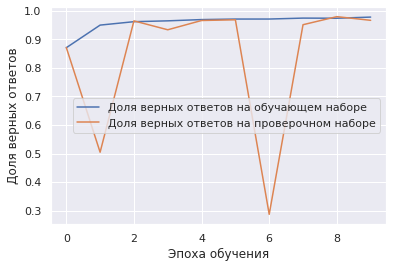

In [118]:
# Выводим график обучения 
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

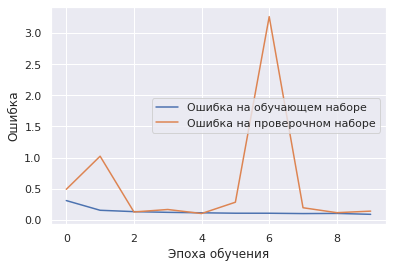

In [121]:
# Выводим графики ошибки
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [122]:
# Вычисляем результаты сети на тестовом наборе
scores = model.evaluate(x_test, y_test, verbose=True)

# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке
print(scores)
print("Доля верных ответов на тестовых данных, в процентах: ", round(scores[1] * 100, 2), "%", sep="")

313/313 [==============================] - 1s 2ms/step - loss: 0.1256 - accuracy: 0.9690
[0.12563228607177734, 0.9690030813217163]
Доля верных ответов на тестовых данных, в процентах: 96.9%


In [123]:
# Значения точности распознавания на проверочной выборке по эпохам
val_acc = history.history['val_accuracy']
for i in range(len(val_acc)):
  print("Эпоха: ", i, " точность: ", round(100*val_acc[i], 1), "%", sep="")

Эпоха: 0 точность: 87.2%
Эпоха: 1 точность: 50.5%
Эпоха: 2 точность: 96.5%
Эпоха: 3 точность: 93.4%
Эпоха: 4 точность: 96.6%
Эпоха: 5 точность: 96.9%
Эпоха: 6 точность: 28.7%
Эпоха: 7 точность: 95.2%
Эпоха: 8 точность: 98.0%
Эпоха: 9 точность: 96.7%


loss - binary_crossentropy - Вычисляет потерю кросс-энтропии между истинными и предсказанными метками. Используйте эту потерю перекрестной энтропии, когда существует только два класса меток (предполагается, что это 0 и 1).

metrics - accuracy - Измеряет количество верно классифицированных объектов относительно общего количества всех объектов